In [378]:
import statsmodels
from statsmodels.tsa.stattools import acf, ccf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import os

import sklearn
import torch
import torch.nn

from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import seaborn as sns

DATA_DIR = './data/'

In [451]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

### Metrics functions

In [446]:
def mrse(actuals, preds):
    actuals = np.array(actuals)
    preds = np.array(preds)

    denom = np.sqrt(np.sum(np.square(actuals - np.mean(actuals))))
    num = np.sqrt(np.sum(np.square(actuals - preds)))

    return 1.0*num/denom

def re(actuals, preds):
    actuals = np.array(actuals)
    preds = np.array(preds)
    denom = np.sqrt(np.sum(np.square(actuals)))
    num = np.sqrt(np.sum(np.square(actuals - preds)))
    return 1.0*num/denom


def error(actuals, preds):
    actuals = np.array(actuals)
    preds = np.array(preds)
    return np.sqrt(np.mean(np.square(actuals-preds)))

## Reading Nino 3.4 data

In [3]:
filename = 'nino34_data.txt'

In [4]:
data = open(DATA_DIR + filename)
data_dict = {}

for line in data.readlines()[1:-3]:
    
    tokens = line.split(' ')
    values = []
    for token in tokens:
        if token == '':
            pass
        else:
            if '\n' in token:
                token = token[:-2]
            values.append(float(token))
    data_dict.update({values[0]:values[1:]})

In [5]:
for key,value in data_dict.items():
    print(key,value)
    assert len(value) == 12

1948.0 [-99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.9]
1949.0 [-99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.9]
1950.0 [24.55, 25.06, 25.87, 26.28, 26.18, 26.46, 26.29, 25.88, 25.74, 25.69, 25.47, 25.2]
1951.0 [25.24, 25.71, 26.9, 27.58, 27.92, 27.73, 27.6, 27.02, 27.23, 27.2, 27.25, 26.9]
1952.0 [26.67, 26.74, 27.17, 27.8, 27.79, 27.18, 26.53, 26.3, 26.36, 26.26, 25.92, 26.2]
1953.0 [26.74, 27.0, 27.57, 28.04, 28.28, 28.12, 27.43, 26.94, 27.01, 26.87, 26.88, 27.0]
1954.0 [26.98, 27.03, 26.9, 26.64, 27.12, 26.8, 26.11, 25.43, 25.12, 25.23, 25.57, 25.2]
1955.0 [25.61, 25.81, 26.22, 26.6, 26.66, 26.55, 26.15, 25.51, 25.28, 24.41, 24.25, 24.5]
1956.0 [25.34, 25.76, 26.46, 26.85, 27.13, 26.81, 26.23, 25.68, 25.73, 25.75, 25.56, 25.7]
1957.0 [26.04, 26.54, 27.46, 28.23, 28.55, 28.36, 28.17, 27.69, 27.44, 27.42, 27.62, 27.9]
1958.0 [28.33, 28.24, 28.27, 28.27, 28.31, 27.99, 27.32, 26.85, 26.4, 26.45

## Filtering data to have 1950 - 2008

In [6]:
filtered_data = {int(year): data_dict[year] for year in data_dict.keys() if year >= 1950 and year <=2008 }

In [7]:
for key,value in filtered_data.items():
    print(key,value)
    assert len(value) == 12

1950 [24.55, 25.06, 25.87, 26.28, 26.18, 26.46, 26.29, 25.88, 25.74, 25.69, 25.47, 25.2]
1951 [25.24, 25.71, 26.9, 27.58, 27.92, 27.73, 27.6, 27.02, 27.23, 27.2, 27.25, 26.9]
1952 [26.67, 26.74, 27.17, 27.8, 27.79, 27.18, 26.53, 26.3, 26.36, 26.26, 25.92, 26.2]
1953 [26.74, 27.0, 27.57, 28.04, 28.28, 28.12, 27.43, 26.94, 27.01, 26.87, 26.88, 27.0]
1954 [26.98, 27.03, 26.9, 26.64, 27.12, 26.8, 26.11, 25.43, 25.12, 25.23, 25.57, 25.2]
1955 [25.61, 25.81, 26.22, 26.6, 26.66, 26.55, 26.15, 25.51, 25.28, 24.41, 24.25, 24.5]
1956 [25.34, 25.76, 26.46, 26.85, 27.13, 26.81, 26.23, 25.68, 25.73, 25.75, 25.56, 25.7]
1957 [26.04, 26.54, 27.46, 28.23, 28.55, 28.36, 28.17, 27.69, 27.44, 27.42, 27.62, 27.9]
1958 [28.33, 28.24, 28.27, 28.27, 28.31, 27.99, 27.32, 26.85, 26.4, 26.45, 26.75, 26.6]
1959 [27.07, 27.18, 27.47, 27.88, 27.7, 27.37, 26.44, 26.09, 25.92, 26.24, 26.04, 26.1]
1960 [26.27, 26.29, 26.98, 27.49, 27.68, 27.24, 26.88, 26.7, 26.44, 26.22, 26.26, 26.2]
1961 [26.23, 26.56, 26.94, 27.36,

## Reading Nino 3.4 Anomaly data

In [8]:
# filename = 'nino34_anomalies.txt'

In [9]:
# anomaly_data = open(DATA_DIR + filename)
# anomaly_data_dict = {}

# for line in anomaly_data.readlines():  
#     _,year,value = line.split(' ')
#     value = float(value[:-2])
#     year = int(float(year))
#     if year in anomaly_data_dict:
#         anomaly_data_dict[year]=anomaly_data_dict[year]+[value]
#     else:
#         anomaly_data_dict.update({year:[value]})

In [10]:
# for key,value in anomaly_data_dict.items():
#     print(key,value)
#     assert len(value) == 12

## Flattening time series data

In [11]:
filtered_ts = np.array([])
filtered_ts = np.array([np.concatenate((filtered_ts,val)) for val in filtered_data.values()]).flatten()

In [12]:
assert len(filtered_ts) == (2008-1950+1)*12

In [13]:
# filtered_anomalies = np.array([])
# filtered_anomalies = np.array([np.concatenate((filtered_anomalies,val)) for val in anomaly_data_dict.values()]).flatten()

In [14]:
# assert len(filtered_anomalies) == (2008-1950+1)*12

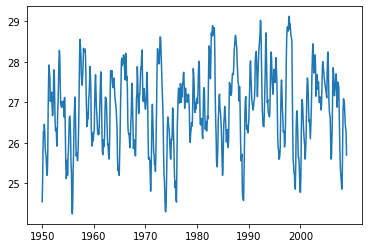

In [15]:
plt.plot(filtered_ts)
plt.xticks(range(0,708+1,12*10),labels=range(1950,2008+1,10))
plt.show()

In [16]:
def get_data(data,years,subtract_mean=False,means=None):
    if subtract_mean == True:
        assert means is not None
    filtered_data = {int(year): data[year] for year in data.keys() if year in years }
    filtered_ts = np.array([])
    if subtract_mean:
        filtered_ts = np.array([np.concatenate((filtered_ts,val-means)) for val in filtered_data.values()]).flatten()
    else:
        filtered_ts = np.array([np.concatenate((filtered_ts,val)) for val in filtered_data.values()]).flatten()
    return filtered_ts

### Train Test Split

In [17]:
train_test_ratio = 0.8
years = np.array(list(filtered_data.keys()))
print('Total years available')
print(years)
print(f'Train Test ratio: {train_test_ratio}')
training_years = years[:int(train_test_ratio*len(years))]
print(f'No of years in training: {len(training_years)}')
print(training_years)
testing_years = years[int(train_test_ratio*len(years)):]
print(f'No of years in testing: {len(testing_years)}')
print(testing_years)

Total years available
[1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008]
Train Test ratio: 0.8
No of years in training: 47
[1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996]
No of years in testing: 12
[1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008]


## Calculating monthly means across all training years

In [18]:
means = np.zeros(12)
for key,value in filtered_data.items():
    if int(key) in training_years:
        means += np.array(value)
means /= len(training_years)
print(means)

[26.43340426 26.63085106 27.10021277 27.51       27.61638298 27.42085106
 26.98765957 26.58851064 26.47744681 26.43723404 26.42957447 26.37021277]


In [19]:
for key,value in filtered_data.items():
    print(key,value-means)
    assert len(value) == 12

1950 [-1.88340426 -1.57085106 -1.23021277 -1.23       -1.43638298 -0.96085106
 -0.69765957 -0.70851064 -0.73744681 -0.74723404 -0.95957447 -1.17021277]
1951 [-1.19340426 -0.92085106 -0.20021277  0.07        0.30361702  0.30914894
  0.61234043  0.43148936  0.75255319  0.76276596  0.82042553  0.52978723]
1952 [ 0.23659574  0.10914894  0.06978723  0.29        0.17361702 -0.24085106
 -0.45765957 -0.28851064 -0.11744681 -0.17723404 -0.50957447 -0.17021277]
1953 [0.30659574 0.36914894 0.46978723 0.53       0.66361702 0.69914894
 0.44234043 0.35148936 0.53255319 0.43276596 0.45042553 0.62978723]
1954 [ 0.54659574  0.39914894 -0.20021277 -0.87       -0.49638298 -0.62085106
 -0.87765957 -1.15851064 -1.35744681 -1.20723404 -0.85957447 -1.17021277]
1955 [-0.82340426 -0.82085106 -0.88021277 -0.91       -0.95638298 -0.87085106
 -0.83765957 -1.07851064 -1.19744681 -2.02723404 -2.17957447 -1.87021277]
1956 [-1.09340426 -0.87085106 -0.64021277 -0.66       -0.48638298 -0.61085106
 -0.75765957 -0.908510

In [20]:
training_data = get_data(filtered_data,training_years,subtract_mean=True,means=means)
# training_anomalies = get_data(anomaly_data_dict,training_years)

In [21]:
test_data = get_data(filtered_data,testing_years,subtract_mean=True,means=means)
# test_anomalies = get_data(anomaly_data_dict,testing_years)

In [22]:
len(training_data)#,len(training_anomalies)

564

In [23]:
assert len(training_years)*12 == len(training_data)
#assert len(training_years)*12 == len(training_anomalies)

### Plotting training data, mean, acf and pacf

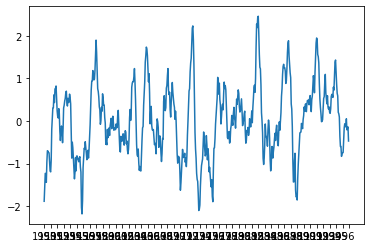

In [24]:
plt.plot(training_data)
plt.xticks(range(0,len(training_data)+1,12),labels=training_years)
plt.show()

In [25]:
# plt.plot(training_anomalies)
# plt.xticks(range(0,len(training_anomalies)+1,12),labels=training_years)
# plt.show()

### Plotting test data

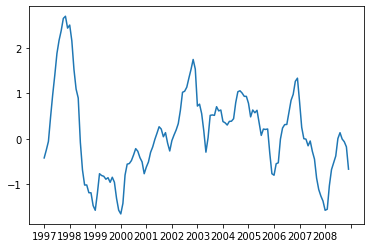

In [26]:
plt.plot(test_data)
plt.xticks(range(0,len(test_data)+1,12),labels=testing_years)
plt.show()

### Plotting train & test data

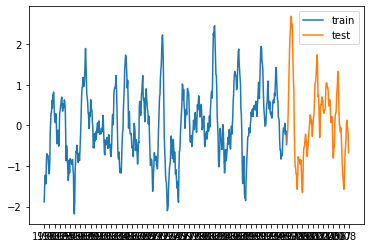

In [27]:
plt.plot(range(0,len(training_data)),training_data,label='train')
plt.plot(range(len(training_data),len(training_data)+len(test_data)),test_data,label='test')
plt.xticks(range(0,len(training_data)+len(test_data)+1,12),labels=list(training_years)+list(testing_years))
plt.legend()
plt.show()

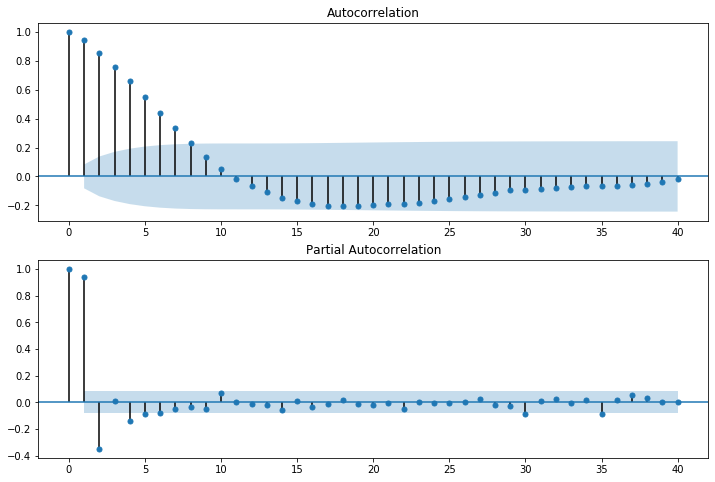

In [28]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(training_data, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(training_data, lags=40, ax=ax2)
plt.show()

## Loading fake non linear data

In [475]:
LOAD_DATA = True

training_data_file_name = f'fake_nonlinear_training_data_{p}.npy'
testing_data_file_name = f'fake_nonlinear_test_data_{p}.npy'

if LOAD_DATA:
    training_data = np.load(training_data_file_name)
    test_data = np.load(testing_data_file_name)
else:
    np.save(training_data_file_name,training_data)
    np.save(testing_data_file_name,test_data)

### Plotting training data, mean, acf and pacf

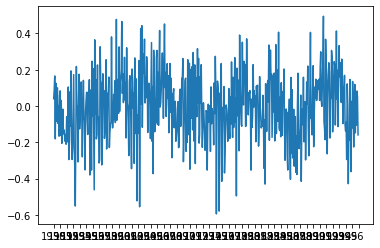

In [476]:
plt.plot(training_data)
plt.xticks(range(0,len(training_data)+1,12),labels=training_years)
plt.show()

### Plotting test data

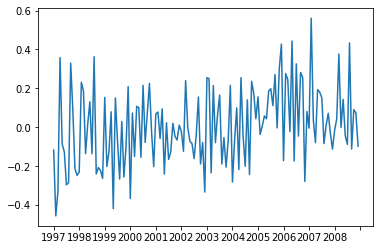

In [477]:
plt.plot(test_data)
plt.xticks(range(0,len(test_data)+1,12),labels=testing_years)
plt.show()

### Plotting train & test data

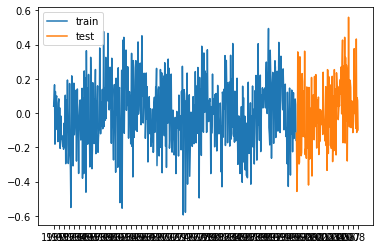

In [478]:
plt.plot(range(0,len(training_data)),training_data,label='train')
plt.plot(range(len(training_data),len(training_data)+len(test_data)),test_data,label='test')
plt.xticks(range(0,len(training_data)+len(test_data)+1,12),labels=list(training_years)+list(testing_years))
plt.legend()
plt.show()

### Scaling data

In [479]:
training_data = np.array(training_data)
test_data = np.array(test_data)

In [424]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_training_data = scaler.fit_transform(training_data.reshape(-1, 1))
scaled_test_data = scaler.transform(test_data.reshape(-1, 1))

In [425]:
# scaled_training_data = training_data - np.tile(means,int(len(training_data)/12))

# test_data = get_data(filtered_data,testing_years)
# test_anomalies = get_data(anomaly_data_dict,testing_years)
# scaled_test_data = test_data - np.tile(means,int(len(test_data)/12))

### Plotting scaled training data, acf and pacf

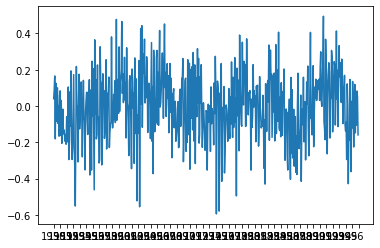

In [480]:
plt.plot(training_data)
#plt.plot(reqd_means)
plt.xticks(range(0,len(training_data)+1,12),labels=training_years)
plt.show()

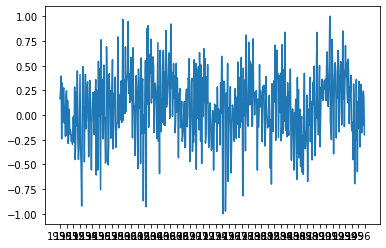

In [481]:
plt.plot(scaled_training_data)
#plt.plot(reqd_means)
plt.xticks(range(0,len(training_data)+1,12),labels=training_years)
plt.show()

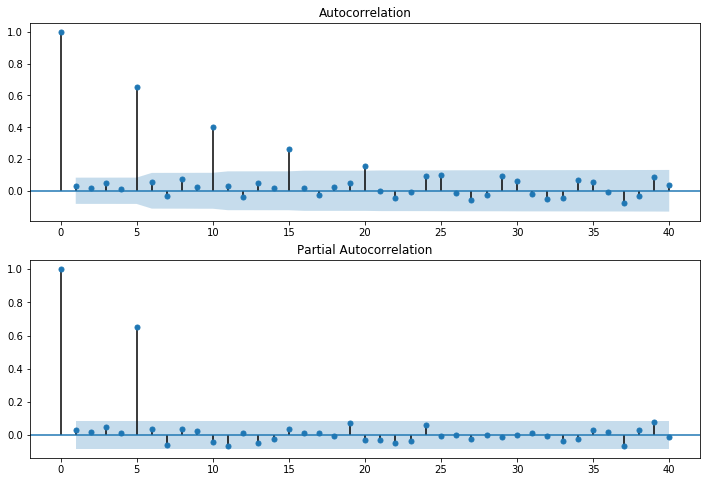

In [482]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(scaled_training_data, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(scaled_training_data, lags=40, ax=ax2)
plt.show()

In [484]:
train_data_normalized = torch.FloatTensor(training_data).view(-1)
train_window = p

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

train_inout_seq[:5]

[(tensor([ 0.0405,  0.0881,  0.1659, -0.1809,  0.1266]), tensor([-0.0851])),
 (tensor([ 0.0881,  0.1659, -0.1809,  0.1266, -0.0851]), tensor([0.0911])),
 (tensor([ 0.1659, -0.1809,  0.1266, -0.0851,  0.0911]), tensor([0.1004])),
 (tensor([-0.1809,  0.1266, -0.0851,  0.0911,  0.1004]), tensor([-0.0955])),
 (tensor([ 0.1266, -0.0851,  0.0911,  0.1004, -0.0955]), tensor([0.0026]))]

In [485]:
test_data_normalized = torch.FloatTensor(test_data).view(-1)

test_inout_seq = create_inout_sequences(test_data_normalized, train_window)

test_inout_seq[:5]

[(tensor([-0.1179, -0.4570, -0.3315,  0.3581, -0.0870]), tensor([-0.1271])),
 (tensor([-0.4570, -0.3315,  0.3581, -0.0870, -0.1271]), tensor([-0.2969])),
 (tensor([-0.3315,  0.3581, -0.0870, -0.1271, -0.2969]), tensor([-0.2859])),
 (tensor([ 0.3581, -0.0870, -0.1271, -0.2969, -0.2859]), tensor([0.3295])),
 (tensor([-0.0870, -0.1271, -0.2969, -0.2859,  0.3295]), tensor([0.0888]))]

In [486]:
print(f'scaled_training_data: {len(scaled_training_data)}\n\
scaled_test_data: {len(scaled_test_data)}\n\
training_data: {len(training_data)}\n\
test_data: {len(test_data)}\n\
train_inout_seq: {len(train_inout_seq)}\n\
test_inout_seq: {len(test_inout_seq)}\n\
')

scaled_training_data: 564
scaled_test_data: 144
training_data: 564
test_data: 144
train_inout_seq: 559
test_inout_seq: 139



In [487]:
import torch.nn as nn
import torch.optim as optim

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=10, num_hidden_layers=1, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_hidden_layers)

        self.linear = nn.Linear(hidden_layer_size, output_size)

#         self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
#                             torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        #lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        format_input = input_seq.view(len(input_seq) ,1, -1)
        lstm_out,_ = self.lstm(format_input)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

### Fitting LSTM model

In [433]:
input_size=1
num_hidden_layers=2
hidden_layer_size=100
output_size=1

model = LSTM(input_size,hidden_layer_size,num_hidden_layers,output_size)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=4)
print(model)

LSTM(
  (lstm): LSTM(1, 100, num_layers=2)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [312]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
#         model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
#                         torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00612151
epoch:  26 loss: 0.00478298


KeyboardInterrupt: 

In [306]:
train_window = 12
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
#         model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
#                         torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
        
print(test_inputs[fut_pred:])

actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[0.12527473270893097, 0.04615384712815285, 0.3274725377559662, 0.2835164964199066, 0.3890109956264496, 0.6175824403762817, 0.9516483545303345, 1.0, 0.5780220031738281, 0.33186814188957214, 0.13406594097614288, 0.32307693362236023]
[0.43903225660324097, 0.3478623628616333, 0.5895549058914185, 0.6298840045928955, 0.7827765941619873, 0.8987748026847839, 1.0964668989181519, 1.1404649019241333, 0.8580102920532227, 0.6915215849876404, 0.6362342238426208, 0.896157443523407]
[[431.37983838]
 [410.63868755]
 [465.62374109]
 [474.79861104]
 [509.58167517]
 [535.97126761]
 [580.9462195 ]
 [590.95576519]
 [526.69734144]
 [488.82116058]
 [476.24328592]
 [535.3758184 ]]


In [308]:
x = np.arange(132, 144, 1)
print(x)

[132 133 134 135 136 137 138 139 140 141 142 143]


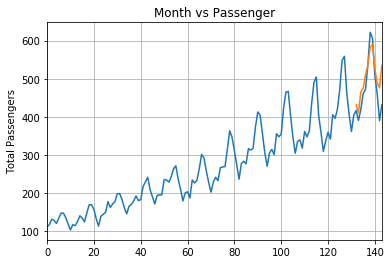

In [309]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(x,actual_predictions)
plt.show()

## FITTING RNN MODEL

In [488]:
def evaluate(rescale=True, display_plots=False):
    model.eval()
    scaled_predictions = []
    scaled_actuals = []
    for i in range(len(test_inout_seq)):
        seq = torch.FloatTensor(test_inout_seq[i][0])
        scaled_actuals.append(test_inout_seq[i][1].item())
        with torch.no_grad():
#             model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
#                             torch.zeros(1, 1, model.hidden_layer_size))
            scaled_predictions.append(model(seq).item())
    if rescale:
        actuals = scaler.inverse_transform(np.array(scaled_actuals).reshape(-1, 1))
        predictions = scaler.inverse_transform(np.array(scaled_predictions).reshape(-1, 1))
    else:
        actuals=scaled_actuals
        predictions=scaled_predictions
    a1 = actuals
    p1 = predictions
    #actuals = test_data
    if display_plots:
        plt.plot(actuals,label='Truth')
        plt.plot(predictions,label='Preds')
        plt.xticks(range(0,len(scaled_test_data)+1,12),labels=testing_years)
        plt.legend()
        plt.show()
    test_mrse = mrse(actuals,predictions)
    test_re = re(actuals,predictions)
    test_error = error(actuals,predictions)
    return test_mrse,test_re,test_error,a1,p1
    #print(f'Test MRSE: {test_mrse}\nTest RE: {test_re}\nTest ERROR: {test_error}')

## GRID SEARCH FOR RNN

In [ ]:
layers = [1,2,3]
sizes = [10,25,50,100,150,200]
epochs = 100
loss_function = nn.MSELoss()
input_size=1
output_size=1
skip_cnt = 0
lr_threshold = 1e-5
best_test_metric = np.inf
best_path = None
for a,l in enumerate(layers):
    for b,s in enumerate(sizes):
        if (a*len(sizes))+(b)<skip_cnt:
            print(f'Skipping num_hidden_layers: {l} hidden_layer_size: {s}')
        else:
            num_hidden_layers=l
            hidden_layer_size=s
            prev_running_loss = np.inf
            model = LSTM(input_size,hidden_layer_size,num_hidden_layers,output_size)
            print(model)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            scheduler = ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=4)
            best_model_params = model.state_dict()
            PATH = f'models/best_rnn_model_{p}_{l}_{s}.pth'

            for i in range(epochs):
                running_loss = 0.0
                cnt=0
                for seq, labels in train_inout_seq:
                    optimizer.zero_grad()
            #         model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
            #                         torch.zeros(1, 1, model.hidden_layer_size))

                    y_pred = model(seq)
                    single_loss = loss_function(y_pred, labels)
                    single_loss.backward()
                    optimizer.step()
                    current_loss = single_loss.item()
                    running_loss += current_loss
                current_lr = get_lr(optimizer)
                if current_lr < lr_threshold:
                    print('LR lower than threshold {lr_threshold}. stopping training')
                    break
                    
#                 if running_loss > prev_running_loss:
#                     print('Training loss started to increase. stopping training...')
#                     prev_running_loss = running_loss
#                     cnt += 1
#                     if cnt > 4:   
#                         break
#                 else:
#                     cnt=0
                prev_running_loss = running_loss
                test_mrse,test_re,test_error,_,_ = evaluate(False,False)
                
                if i%5 == 1:
                    print(f'epoch: {i:3} loss: {running_loss:10.8f}')
                test_metric = test_error 
                scheduler.step(test_metric)
                if(test_metric < best_test_metric):
                    count = 0
                    best_test_metric = test_metric
                    best_path = PATH
                    torch.save({
                        'state_dict': model.state_dict(),
                        }, PATH)
                    print(f"Best Model saved at epoch: {i} with metric: {best_test_metric} num_hidden_layers: {l} hidden_layer_size: {s}")
                else:
                    count+=1
            #     if(count >= 5):
            #         print("Validation has not improved since 5 epochs. Early Stopping...")
            #         break
            print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

LSTM(
  (lstm): LSTM(1, 10)
  (linear): Linear(in_features=10, out_features=1, bias=True)
)
Best Model saved at epoch: 0 with metric: 0.18937499025211924 num_hidden_layers: 1 hidden_layer_size: 10
epoch:   1 loss: 20.06601047
Best Model saved at epoch: 1 with metric: 0.1884467858088359 num_hidden_layers: 1 hidden_layer_size: 10
Best Model saved at epoch: 2 with metric: 0.18629527799130463 num_hidden_layers: 1 hidden_layer_size: 10
Best Model saved at epoch: 3 with metric: 0.17626888490746082 num_hidden_layers: 1 hidden_layer_size: 10
Best Model saved at epoch: 4 with metric: 0.16757228968858973 num_hidden_layers: 1 hidden_layer_size: 10
Best Model saved at epoch: 5 with metric: 0.1659798140535323 num_hidden_layers: 1 hidden_layer_size: 10
epoch:   6 loss: 14.16298587
Best Model saved at epoch: 6 with metric: 0.16570575267704832 num_hidden_layers: 1 hidden_layer_size: 10
Best Model saved at epoch: 7 with metric: 0.16546909823655995 num_hidden_layers: 1 hidden_layer_size: 10
Best Model s

In [ ]:
num_hidden_layers=int(best_path.split('_')[-2])
hidden_layer_size=int(best_path.split('_')[-1].split('.')[0])

In [ ]:
best_path,num_hidden_layers,hidden_layer_size

In [ ]:
model = LSTM(input_size,hidden_layer_size,num_hidden_layers,output_size)
model_dict = torch.load(best_path)
model.load_state_dict(model_dict['state_dict'])
test_mrse,test_re,test_error,a1,p1 = evaluate(rescale=False,display_plots=True)
print(f'Test MRSE: {test_mrse}\nTest RE: {test_re}\nTest ERROR: {test_error}')